In [89]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Binary target variable, indicates tree mortality one year after fire (0 = alive, 1 = dead).
| YrFireName                  | Name or indetifier of fire event the tree was involved in.                                    
| Times_burned                | Number of times tree has experienced fire, prior to recorded event.                                             
| Species                     | Categorical variable representing tree species name.                                                    
| Genus_species               | Species genus and species name.                                       
| DBH_cm                      | Diameter of tree at breast height in centimeters.
| HT_m                        | Height of tree in meters.
| CR_pre                      | Crown ratio before fire event.
| CR_post                     | Crown ratio after fire event.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [90]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv', low_memory=False)

# Select the relevant features
features = ['YrFireName', 
            'Times_burned', 
            'Species', 
            'Genus_species', 
            'DBH_cm', 
            'HT_m', 
            'CR_pre', 
            'CR_post']
target = 'yr1status'

# Filter dataset to only include selected features and the target
trees_data = trees_dat[features + [target]]

# Drop rows with missing target variable and any rows that might have NaNs in key predictors
trees_data = trees_data.dropna()

# Number of observations
print(f"Number of observations after removing NaNs: {trees_data.shape[0]}")

Number of observations after removing NaNs: 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [91]:
# List of categorical columns
categorical_columns = ['YrFireName', 'Species', 'Genus_species']

# Apply factorize to each categorical column 
trees_data[categorical_columns] = trees_data[categorical_columns].apply(lambda x: pd.factorize(x)[0])

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [93]:
# Split the data into training and testing sets
X = trees_data[features]
y = trees_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the predictors
scaler = StandardScaler()
# Scale the training data and keep feature names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# Scale the test data and keep feature names
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [94]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [95]:
# Create a Logistic Regression classifier
logreg = LogisticRegression(random_state=42)

# Fit the model on the training data
logreg.fit(X_train_scaled, y_train)

# Make predictions on the training data
y_train_pred = logreg.predict(X_train_scaled)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9436


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.9393


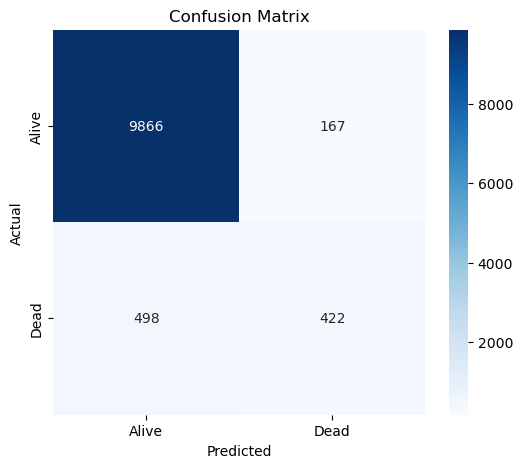

In [96]:
# Make predictions on the test set
y_test_pred = logreg.predict(X_test_scaled)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {test_accuracy:.4f}")


#Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", # Integer format (decimal)
            cmap="Blues", 
            xticklabels=["Alive", "Dead"], 
            yticklabels=["Alive", "Dead"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

*The model performed well on the data it was trained on, with a 94.36% accuracy. The model then performed well on the unseen data, with 93.93% accuracy. Since the test accuracy is very close to the training accuracy, this suggests that the model is not overfitting, which is great! The drop in accuracy is small, meaning the model generalizes well from the training data to unseen data. The model predicts alive instances with more accuracy that dead instances but still does fairly well. There is a bit of an imbalance for alive and dead observations, with more alive instances.*

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

*A dummy that would always predict all dead trees would give more false negatives by predicting alive trees as dead. This would potentially make accuracy lower compared to the logistic regression model, specifically for alive trees would be predicted as dead. Dead trees would be overpredicted to ensure all actual dead trees are counted.*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [105]:
# Create the DummyClassifier with the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# Train the DummyClassifier on the training data
dummy_clf.fit(X_train_scaled, y_train)

# Make predictions on the training data
y_train_pred_dummy = dummy_clf.predict(X_train_scaled)

# Calculate the accuracy of the DummyClassifier on the training data
train_accuracy_dummy = accuracy_score(y_train, y_train_pred_dummy)

# Generate the confusion matrix
cm_dummy = confusion_matrix(y_train, y_train_pred_dummy)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {train_accuracy_dummy:.4f}")
print("\nDummy Confusion Matrix:")
print(cm_dummy)

Dummy Accuracy: 0.9172

Dummy Confusion Matrix:
[[23441     0]
 [ 2115     0]]


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [98]:
# Logistic classifier AUC
y_train_prob_logreg = logreg.predict_proba(X_train_scaled)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_train, y_train_prob_logreg)
roc_auc_logreg = roc_auc_score(y_train, y_train_prob_logreg)
# Print 
print(f"Logistic AUC: {roc_auc_logreg:.4f}")

Logistic AUC: 0.9169


In [99]:
# Dummy classifier AUC
y_train_prob_dummy = dummy_clf.predict_proba(X_train_scaled)[:, 1]
fpr_dummy, tpr_dummy, _ = roc_curve(y_train, y_train_prob_dummy)
roc_auc_dummy = roc_auc_score(y_train, y_train_prob_dummy)
# Print
print(f"Dummy AUC: {roc_auc_dummy:.4f}")

Dummy AUC: 0.5000


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

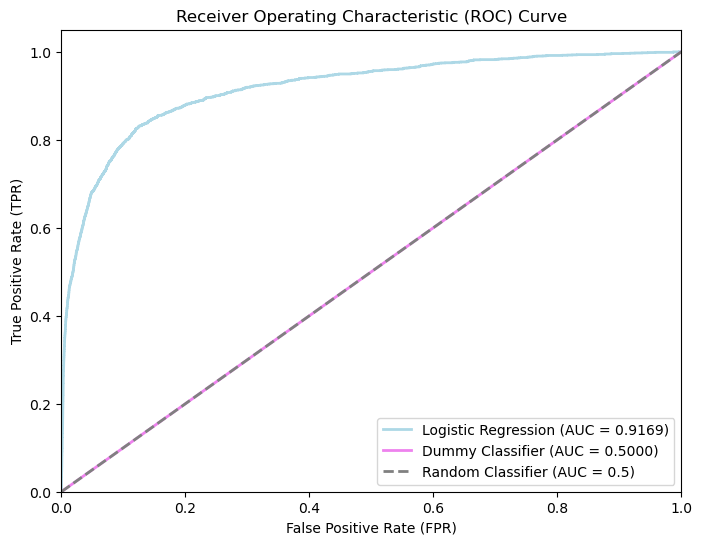

In [71]:
# Plot ROC Curves for both models (Logistic Regression and Dummy Classifier)
plt.figure(figsize=(8, 6))

# Plot ROC curve for Logistic Regression
plt.plot(fpr_logreg, tpr_logreg, color='lightblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.4f})')

# Plot ROC curve for Dummy Classifier
plt.plot(fpr_dummy, tpr_dummy, color='violet', lw=2, label=f'Dummy Classifier (AUC = {roc_auc_dummy:.4f})')

# Plot the random classifier line (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random Classifier (AUC = 0.5)")

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Show legend
plt.legend(loc='lower right')

# Display the plot
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*The logistic regression model AUC at 0.9169 significantly outperforms the dummy classifier AUC at 0.5000. The logistic regression model is much better at distinguishing between alive trees and dead trees, which is clear from the high AUC. The dummy classifier’s AUC of 0.5 indicates it is essentially useless for separating the classes, which aligns with our expectation since the dummy classifier always predicts the majority class. The AUC provides more insight into the model's ability to rank or differentiate between classes than accuracy does, especially in the context of imbalanced datasets.*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [72]:
# Get the feature importance (coefficients) from the Logistic Regression model
coefficients = logreg.coef_[0]  # Extract coefficients from the fitted model (1D array)

# Create a DataFrame to hold the feature names and their corresponding coefficients
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Add a column for the absolute value of the coefficients (for sorting)
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()

# Sort the features by the absolute value of the coefficient (from most to least important)
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print the sorted feature importance
print(importance_df[['Feature', 'Coefficient', 'Abs_Coefficient']])

         Feature  Coefficient  Abs_Coefficient
7        CR_post    -2.268484         2.268484
5           HT_m    -0.996278         0.996278
4         DBH_cm     0.413430         0.413430
3  Genus_species     0.180301         0.180301
2        Species     0.180301         0.180301
0     YrFireName    -0.133544         0.133544
6         CR_pre     0.026231         0.026231
1   Times_burned     0.000000         0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*The most important feature negatively suggests crown ratio recovery post-fire is associated with higher mortality. The height of the tree has a strong influence on survival, with taller trees being more vulnerable. Larger trees by breast height diameter are more likely to survive, due to better physical resilience. Different species and genera have different levels of fire resilience, which affects survival rates. Fires from certain years, likely those with more extreme conditions, are associated with higher mortality rates. The pre-fire crown ratio has a minor positive effect, suggesting trees in better condition before the fire have a slight edge in surviving. Since trees that experience poor recovery post-fire are more likely to die. Forest managers should focus on restoring vegetation and ecosystem functions after a fire, including reducing soil erosion, promoting nutrient health, and encouraging quick regrowth of surrounding vegetation to provide cover protection for trees.*